# ***Introduction***
Develope by Prof. Dr. Helen Lu, helen.lu@vlerick.com (c) 2026

We use a US SEO dataset to train ML models to predict new equity issuance.

**Models and hyperparameter-tuning:**
*   Logit: no tuning
*   Light Gradient Boosting Machine (LightGBM): min_child_samples = max(1% of train, 50); early stopping



**Evaluation:**
Compare two models
1.   ROC AUC
1.   Avg predicted prob % vs actual SEO % across 10 deciles
1.   Show two-way SHAP plots using winsorized feature values for plotting only (no winsorization in training/prediction)




In [20]:
# Imports libraries
import re
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score

import lightgbm as lgb
import shap
import matplotlib.pyplot as plt

In [21]:
# Load data and train/validation/test split
DATA_PATH = "https://raw.githubusercontent.com/helenlu-vbs/AI-for-Corporate-Finance-UGent-/refs/heads/main/SEO_teaching.csv"
df = pd.read_csv(DATA_PATH)

def yq_to_int(yq: str) -> int:
    m = re.match(r"(\d{4})q([1-4])", str(yq).lower())
    if m is None:
        raise ValueError(f"Bad yq format: {yq}")
    year, q = int(m.group(1)), int(m.group(2))
    return year * 4 + (q - 1)

df["yq_int"] = df["yq"].apply(yq_to_int)

TEST_START = yq_to_int("2019q3")
TEST_END   = yq_to_int("2020q4")

train = df[df["yq_int"] < TEST_START].copy()
test  = df[(df["yq_int"] >= TEST_START) & (df["yq_int"] <= TEST_END)].copy()

target = "seo_flag"
id_cols = ["gvkey", "yq", "yq_int"]
features = [c for c in df.columns if c not in id_cols + [target]]

X_train = train[features]
y_train = train[target].astype(int).values
X_test  = test[features]
y_test  = test[target].astype(int).values

print("Train:", train.shape, " Pos:", int(y_train.sum()), " Rate:", y_train.mean())
print("Test :", test.shape,  " Pos:", int(y_test.sum()),  " Rate:", y_test.mean())




Train: (15115, 15)  Pos: 111  Rate: 0.007343698312934172
Test : (4219, 15)  Pos: 50  Rate: 0.011851149561507466


In [22]:
# model training
# ------------------------------------------------------------
# Logit
# ------------------------------------------------------------
logit_l2 = Pipeline([
    ("clf", LogisticRegression(
        C=1.0,
        solver="lbfgs",
        max_iter=5000
    ))
])
logit_l2.fit(X_train, y_train)
p_logit = logit_l2.predict_proba(X_test)[:, 1]


# ------------------------------------------------------------
#    LightGBM — only min leaf + early stopping
#    Early stopping needs a validation set. We'll do time-based:
#    last 4 quarters of TRAIN are validation (fallback to last 20% if needed).
# ------------------------------------------------------------
train = train.sort_values("yq_int")
unique_q = np.sort(train["yq_int"].unique())

val_q = unique_q[-4:]               # last 4 quarters as validation
tr_q  = unique_q[:-4]
tr_idx = train["yq_int"].isin(tr_q)
va_idx = train["yq_int"].isin(val_q)

X_tr, y_tr = train.loc[tr_idx, features], train.loc[tr_idx, target].astype(int).values
X_va, y_va = train.loc[va_idx, features], train.loc[va_idx, target].astype(int).values

min_leaf = max(int(0.01 * len(train)), 50)
print("LightGBM min_child_samples =", min_leaf)

lgbm = lgb.LGBMClassifier(
    objective="binary",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    force_col_wise=True,

    # keep parameters simple for class; early stopping will pick best_iteration
    n_estimators=5000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_samples=min_leaf
)

lgbm.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

# After early-stopping fit:
best_iter = lgbm.best_iteration_
print("Best iteration from early stopping:", best_iter)

# Combine train + val
X_full = pd.concat([X_tr, X_va], axis=0)
y_full = np.concatenate([y_tr, y_va], axis=0)

# Refit on full (train+val) using best_iter
lgbm_final = lgb.LGBMClassifier(
    objective="binary",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    force_col_wise=True,

    n_estimators=best_iter,      # <-- key line
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_samples=min_leaf
)

lgbm_final.fit(X_full, y_full)

# Use the refit model for test predictions
p_lgbm = lgbm_final.predict_proba(X_test)[:, 1]


LightGBM min_child_samples = 151
[LightGBM] [Info] Number of positive: 101, number of negative: 11643
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 11744, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's auc: 0.608658	valid_0's binary_logloss: 0.113156
Best iteration from early stopping: 95
[LightGBM] [Info] Number of positive: 111, number of negative: 15004
[LightGBM] [Info] Total Bins 2579
[LightGBM] [Info] Number of data points in the train set: 15115, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [23]:
# Evaluation
# ------------------------------------------------------------
# Compare ROC AUC (test)
# ------------------------------------------------------------
auc_logit = roc_auc_score(y_test, p_logit)
auc_lgbm  = roc_auc_score(y_test, p_lgbm)

print("\n=== Test ROC AUC ===")
print(f"Logit:        {auc_logit:.4f}")
print(f"LightGBM:          {auc_lgbm:.4f}")



=== Test ROC AUC ===
Logit:        0.5643
LightGBM:          0.7046


In [24]:
# Evaluation
# 1) % of firms issued equity, across 10 deciles (1 = lowest probabilities of SEO; 10 = highest probability)
# Create a DataFrame for test predictions and actual values
results_df = pd.DataFrame({
    'y_test': y_test,
    'p_logit': p_logit,
    'p_lgbm': p_lgbm
})

# --- Process Logit predictions ---
results_df_logit = results_df.sort_values(by='p_logit', ascending=True).reset_index(drop=True)
results_df_logit['decile'] = pd.qcut(results_df_logit['p_logit'], 10, labels=False, duplicates='drop') + 1

# Calculate actual SEO % for each logit decile
logit_decile_analysis = results_df_logit.groupby('decile')['y_test'].agg(['count', 'sum', 'mean'])
logit_decile_analysis.columns = ['Count', 'Actual_SEO_Count', 'Logit_Actual_SEO_Pct']
logit_decile_analysis['Logit_Actual_SEO_Pct'] = logit_decile_analysis['Logit_Actual_SEO_Pct'] * 100

# --- Process LightGBM predictions ---
results_df_lgbm = results_df.sort_values(by='p_lgbm', ascending=True).reset_index(drop=True)
results_df_lgbm['decile'] = pd.qcut(results_df_lgbm['p_lgbm'], 10, labels=False, duplicates='drop') + 1

# Calculate actual SEO % for each LightGBM decile
lgbm_decile_analysis = results_df_lgbm.groupby('decile')['y_test'].agg(['count', 'sum', 'mean'])
lgbm_decile_analysis.columns = ['Count', 'Actual_SEO_Count', 'LightGBM_Actual_SEO_Pct']
lgbm_decile_analysis['LightGBM_Actual_SEO_Pct'] = lgbm_decile_analysis['LightGBM_Actual_SEO_Pct'] * 100

# Combine results for side-by-side comparison
comparison_df = pd.concat([logit_decile_analysis[['Logit_Actual_SEO_Pct']], lgbm_decile_analysis[['LightGBM_Actual_SEO_Pct']]], axis=1)
comparison_df.index.name = 'Decile'
display(comparison_df.round(2))

,Logit_Actual_SEO_Pct,LightGBM_Actual_SEO_Pct
Decile,,
1,0.47,0.00
2,1.18,0.95
3,0.71,0.71
4,0.95,1.42
5,2.13,0.00
6,1.19,0.71
7,0.95,0.24
8,0.71,1.18
9,2.13,2.61


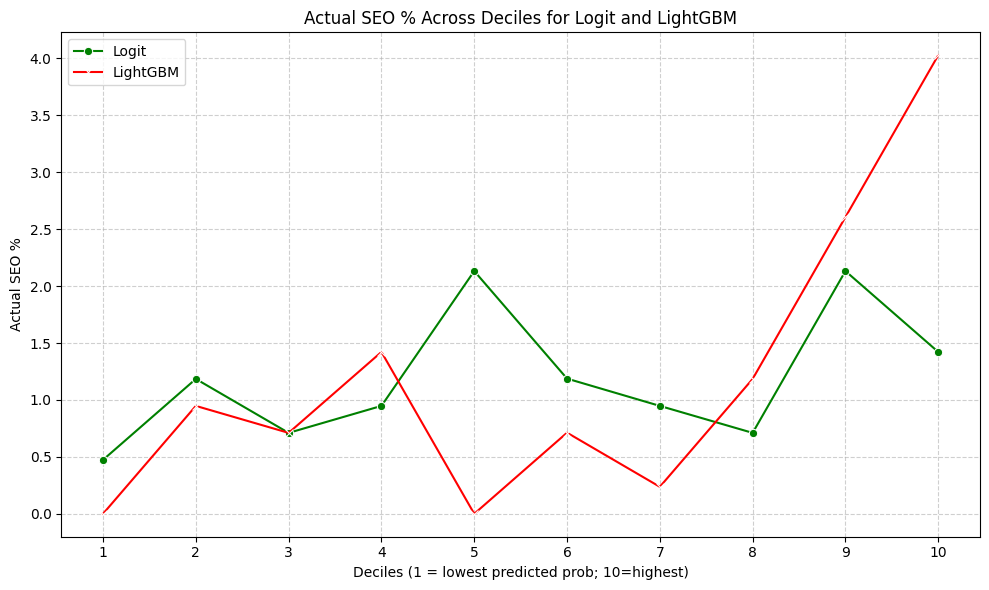

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure comparison_df is available, assuming it's from the previous cell's output
# If not, you might need to re-run the previous cell or load it.

plt.figure(figsize=(10, 6))
sns.lineplot(x=comparison_df.index, y=comparison_df['Logit_Actual_SEO_Pct'], color='green', marker='o', label='Logit')
sns.lineplot(x=comparison_df.index, y=comparison_df['LightGBM_Actual_SEO_Pct'], color='red', marker='x', label='LightGBM')

plt.title('Actual SEO % Across Deciles for Logit and LightGBM')
plt.xlabel('Deciles (1 = lowest predicted prob; 10=highest)')
plt.ylabel('Actual SEO %')
plt.xticks(comparison_df.index)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Local SHAP plot for Amgen Inc. 2020Q4 prediction (Amgen issued shares in 2020Q4)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



=== Local SHAP demo: Amgen Inc. 2020Q4 ===
Index: 8184 | GVKEY: 19172 | yq: 2020q4
Actual seo_flag in this dataset: 1
Predicted probability (LightGBM): 0.688846


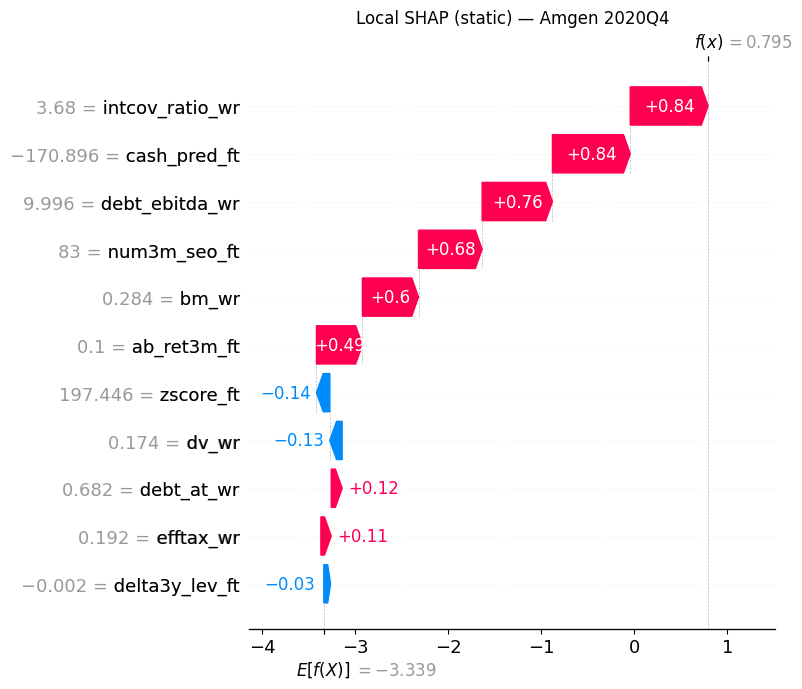

In [26]:
# ============================================================
# END SECTION — Local SHAP for Amgen 2020Q4 + Global SHAP (L1) +
#               Top-2 feature SHAP dependence plots (winsorized for plot only)
# ============================================================
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# -------------------------
# 0) Pick the model + inputs
# -------------------------
model_for_shap = lgbm_final if "lgbm_final" in globals() else lgbm

# Use the same matrix used for prediction if available
X_shap = X_test.values
X_display = X_test  # original (not winsorized) for local plot display

# For SHAP consistency with LightGBM, use booster if present
booster = model_for_shap.booster_ if hasattr(model_for_shap, "booster_") else model_for_shap
explainer = shap.TreeExplainer(booster)

shap_values = explainer.shap_values(X_shap)
# For binary classification SHAP may return a list; take positive class
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# Expected value may also be a list depending on SHAP version
base_value = explainer.expected_value
if isinstance(base_value, (list, np.ndarray)):
    base_value = base_value[1]

# -------------------------
# 1) Local SHAP: Amgen 2020Q4
# -------------------------
# GVKEY for Amgen in Compustat North America is commonly listed as 1602 in public mapping files.
AMGEN_GVKEY = 19172
AMGEN_YQ = "2020q4"

amgen_rows = test.index[(test["gvkey"] == AMGEN_GVKEY) & (test["yq"] == AMGEN_YQ)]
if len(amgen_rows) == 0:
    raise RuntimeError(f"No Amgen row found in test for gvkey={AMGEN_GVKEY}, yq={AMGEN_YQ}.")
amgen_idx = amgen_rows[0]

# Position of that row in X_test / p_lgbm arrays
amgen_pos = list(X_test.index).index(amgen_idx)

# Print summary
amgen_info = test.loc[amgen_idx, ["gvkey", "yq"]]
y_amgen = int(test.loc[amgen_idx, "seo_flag"]) if "seo_flag" in test.columns else None
p_amgen = float(p_lgbm[amgen_pos])

print("\n=== Local SHAP demo: Amgen Inc. 2020Q4 ===")
print(f"Index: {amgen_idx} | GVKEY: {amgen_info['gvkey']} | yq: {amgen_info['yq']}")
if y_amgen is not None:
    print(f"Actual seo_flag in this dataset: {y_amgen}")
print(f"Predicted probability (LightGBM): {p_amgen:.6f}")

# Local force plot (NO winsorization; show 2 decimals in displayed features)
amgen_features_2dp = X_display.loc[amgen_idx, features].astype(float).round(2)

from pathlib import Path
import matplotlib.pyplot as plt
import shap

Path("figures").mkdir(exist_ok=True)

def save_and_show(fname):
    plt.tight_layout()
    plt.savefig(f"figures/{fname}", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

# Build a SHAP Explanation for Amgen row
amgen_exp = shap.Explanation(
    values=shap_values[amgen_pos],
    base_values=base_value,
    data=X_display.loc[amgen_idx, features].values,
    feature_names=features
)

shap.plots.waterfall(amgen_exp, max_display=12, show=False)
plt.title("Local SHAP (static) — Amgen 2020Q4")
save_and_show("amgen_2020q4_local_shap_waterfall.png")


In [27]:

# ----------------------------------------------------------
# 2) Global SHAP table using L1-normalized |SHAP| per instance
#    For each observation i: w_ij = |shap_ij| / sum_k |shap_ik|
#    Then global importance = average_i w_ij
# ----------------------------------------------------------
abs_shap = np.abs(shap_values)
row_l1 = abs_shap.sum(axis=1, keepdims=True)
row_l1 = np.where(row_l1 == 0, 1.0, row_l1)          # guard against divide-by-zero
shap_l1 = abs_shap / row_l1                           # instance-level L1-normalized contributions

global_l1_mean = shap_l1.mean(axis=0)                 # averages sum to 1 across features

global_tbl = pd.DataFrame({
    "feature": features,
    "mean_L1_contrib": global_l1_mean,

}).sort_values("mean_L1_contrib", ascending=False)

print("\n=== Global SHAP (instance-level L1-normalized) — top 15 ===")
print(global_tbl.head(15).to_string(index=False))




=== Global SHAP (instance-level L1-normalized) — top 15 ===
        feature  mean_L1_contrib
intcov_ratio_wr         0.148761
   cash_pred_ft         0.111725
          bm_wr         0.104944
          dv_wr         0.100337
 debt_ebitda_wr         0.098508
      zscore_ft         0.094630
     debt_at_wr         0.088916
   num3m_seo_ft         0.086186
    ab_ret3m_ft         0.070444
      efftax_wr         0.053581
 delta3y_lev_ft         0.041967



Top 2 features by mean L1-normalized |SHAP|: intcov_ratio_wr, cash_pred_ft


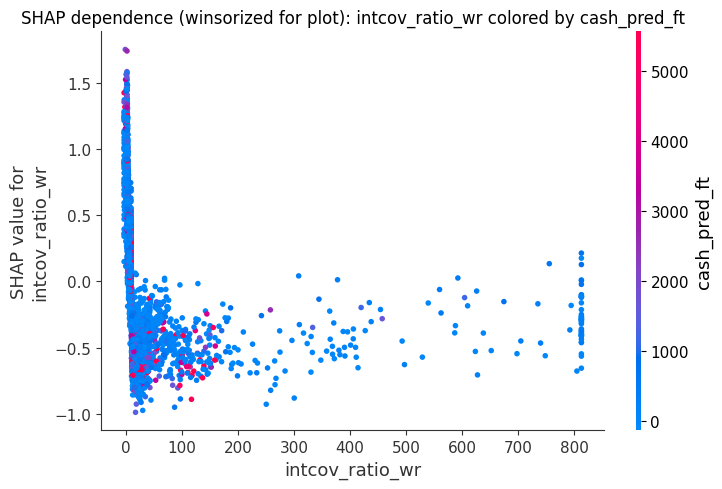

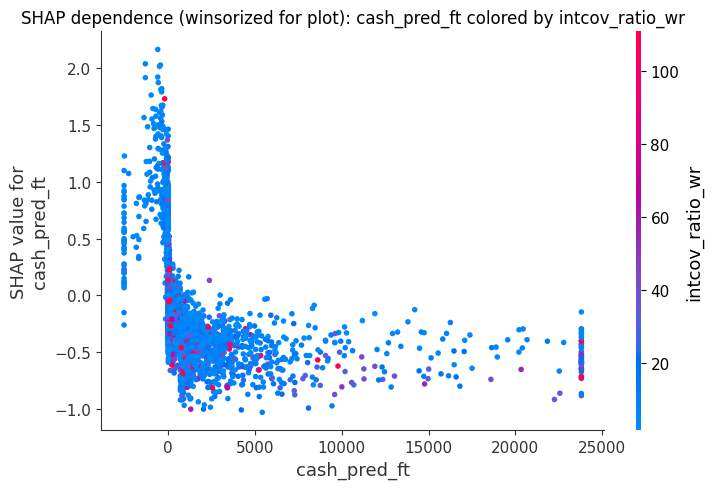

In [28]:

# ----------------------------------------------------------
# 3) SHAP plots for the top two features (one plot each),
#    using winsorized features for plotting ONLY (not training/prediction)
# ----------------------------------------------------------
top2 = global_tbl["feature"].head(2).tolist()
f1, f2 = top2[0], top2[1]
print(f"\nTop 2 features by mean L1-normalized |SHAP|: {f1}, {f2}")

# Winsorize for plotting only (1% / 99% clip) and show 2 decimals on axes
X_test_ws = X_display[features].copy()
for c in features:
    s = pd.to_numeric(X_test_ws[c], errors="coerce")
    lo, hi = s.quantile(0.01), s.quantile(0.99)
    X_test_ws[c] = s.clip(lo, hi)
X_test_ws = X_test_ws.round(2)

# Plot 1: dependence for top feature (colored by 2nd feature)
shap.dependence_plot(
    ind=f1,
    shap_values=shap_values,
    features=X_test_ws,
    interaction_index=f2,
    show=False
)
plt.title(f"SHAP dependence (winsorized for plot): {f1} colored by {f2}")
plt.tight_layout()
plt.show()

# Plot 2: dependence for 2nd feature (colored by top feature)
shap.dependence_plot(
    ind=f2,
    shap_values=shap_values,
    features=X_test_ws,
    interaction_index=f1,
    show=False
)
plt.title(f"SHAP dependence (winsorized for plot): {f2} colored by {f1}")
plt.tight_layout()
plt.show()